In [41]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tqdm import tqdm
import matplotlib.pyplot as plt

## Data

In [42]:
sheets = ["st_rev", "oancfy", "xoprq", "FEDFUNDS", "PERMITS", "UEMPLT5", "excess_return"]
d = {s: pd.read_excel("./train_dataset.xlsx", sheet_name=s).drop("conm", axis=1) for s in sheets}
re = d.pop("excess_return").values
val_sheets = ["st_rev", "oancfy", "xoprq", "FEDFUNDS", "PERMITS", "UEMPLT5", "excess_return"]
val_d = {s: pd.read_excel("./validation_dataset.xlsx", sheet_name=s).drop("conm", axis=1) for s in val_sheets}
val_re = val_d.pop("excess_return").values
index_re = pd.read_excel("./index.xlsx", index_col="date")["index_excess_return"]

In [ ]:
# normalize data (except returns)
d_stats = {k: (v.values.mean(), v.values.std()) for k, v in d.items()}
d_norm = {k: (v - d_stats[k][0])/d_stats[k][1] for k, v in d.items()}
val_d_norm = {k: (v - d_stats[k][0])/d_stats[k][1] for k, v in val_d.items()}

In [ ]:
X = np.stack([v.values for v in d_norm.values()]).T
val_X = np.stack([v.values for v in val_d_norm.values()]).T
re_tp1 = re.T[1:, :]
val_re_tp1 = val_re.T[1:, :]

## Training

2.525E+03: 100%|██████████| 12000/12000 [00:38<00:00, 313.86it/s]


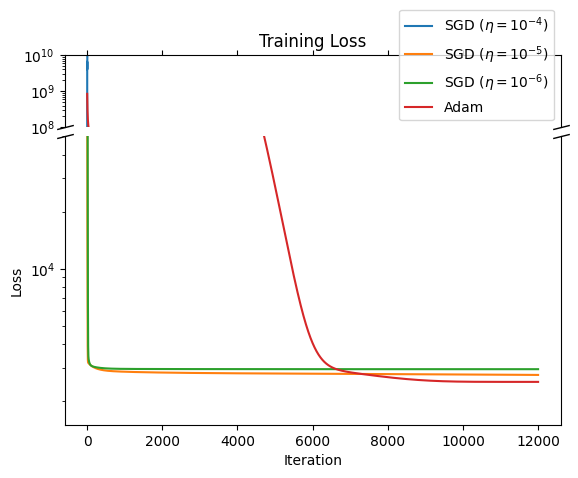

In [ ]:
def optimize(l, verbose=True, optimizer=tf.optimizers.legacy.SGD(1e-5)):
    b = tf.Variable(np.random.uniform(size=X[0, 0].shape))
    gamma = tf.Variable(np.random.uniform(size=(1,)))
    optimizer = optimizer
    losses = []
    vlosses = []
    try:
        for _ in (pbar := (tqdm if verbose else lambda x: x)(range(12000))):
            with tf.GradientTape() as tape:
                omega_t = tf.einsum("ijk, k -> ij", X[:-1, :, :], b)
                M_tp1 = 1. - tf.reduce_sum(omega_t * re_tp1[:], axis=1, keepdims=True)/gamma
                loss = tf.reduce_sum(M_tp1 ** 2 * tf.reduce_sum(re_tp1[:] ** 2, axis=1)) + l * tf.reduce_mean((tf.reduce_sum(omega_t, axis=1) - 1.) ** 2)
            gradients = tape.gradient(loss, [b, gamma])
            optimizer.apply_gradients(zip(gradients, [b, gamma]))
            del tape
            if np.isnan(loss.numpy()) or loss.numpy() > 1e12:
                break
            losses.append(loss.numpy())
            vlosses.append(tf.reduce_sum((1. - tf.reduce_sum(tf.einsum("ijk, k -> ij", val_X[:-1, :, :], b) * val_re_tp1[:], axis=1, keepdims=True)/gamma) ** 2 * tf.reduce_sum(val_re_tp1[:] ** 2, axis=1)) + l * tf.reduce_mean((tf.reduce_sum(tf.einsum("ijk, k -> ij", val_X[:-1, :, :], b), axis=1) - 1.) ** 2).numpy())
            if verbose:
                pbar.set_description(f"{float(loss.numpy()):.3E}")
    except KeyboardInterrupt:
        pass
    return b, losses, vlosses

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, height_ratios=[.2, .8])
fig.subplots_adjust(hspace=0.05)
b, losses, vlosses1 = optimize(2., optimizer=tf.optimizers.legacy.SGD(1e-4))
ax2.semilogy(losses, label="SGD ($\eta = 10^{-4}$)")
ax1.semilogy(losses, label="SGD ($\eta = 10^{-4}$)")
b, losses, vlosses2 = optimize(2., optimizer=tf.optimizers.legacy.SGD(1e-5))
ax2.semilogy(losses, label="SGD ($\eta = 10^{-5}$)")
ax1.semilogy(losses, label="SGD ($\eta = 10^{-5}$)")
b, losses, vlosses3 = optimize(2., optimizer=tf.optimizers.legacy.SGD(1e-5))
ax2.semilogy(losses, label="SGD ($\eta = 10^{-6}$)")
ax1.semilogy(losses, label="SGD ($\eta = 10^{-6}$)")
b, losses, vlosses4 = optimize(2., optimizer=tf.optimizers.legacy.Adam())
ax2.semilogy(losses, label="Adam")
ax1.semilogy(losses, label="Adam")
ax2.set_ylim(1.5e3, 5e4)
ax1.set_ylim(1e8, 1e10)
ax1.spines.bottom.set_visible(False)
ax2.spines.top.set_visible(False)
ax1.xaxis.tick_top()
ax1.tick_params(labeltop=False)
ax2.xaxis.tick_bottom()
d = .25  # proportion of vertical to horizontal extent of the slanted line
kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12,
              linestyle="none", color='k', mec='k', mew=1, clip_on=False)
ax1.plot([0, 1], [0, 0], transform=ax1.transAxes, **kwargs)
ax2.plot([0, 1], [1, 1], transform=ax2.transAxes, **kwargs)
ax1.legend()
ax1.set_title("Training Loss")
plt.ylabel("Loss")
plt.xlabel("Iteration")
plt.show()

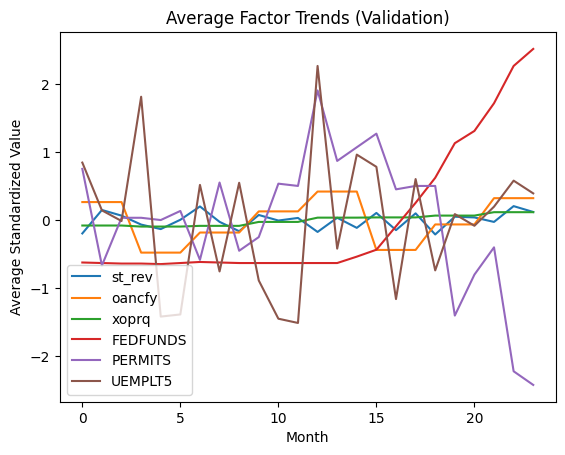

In [76]:
plt.plot(np.mean(val_X, axis=1))
plt.legend(labels=val_d.keys(), loc="lower left")
plt.xlabel("Month")
plt.ylabel("Average Standardized Value")
plt.title("Average Factor Trends (Validation)")
plt.show()

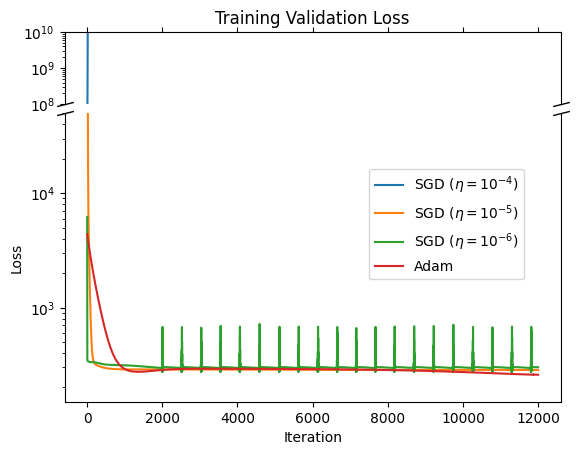

In [64]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, height_ratios=[.2, .8])
fig.subplots_adjust(hspace=0.05)
ax2.semilogy(vlosses1, label="SGD ($\eta = 10^{-4}$)")
ax1.semilogy(vlosses1, label="SGD ($\eta = 10^{-4}$)")
ax2.semilogy(vlosses2, label="SGD ($\eta = 10^{-5}$)")
ax1.semilogy(vlosses2, label="SGD ($\eta = 10^{-5}$)")
ax2.semilogy(vlosses3, label="SGD ($\eta = 10^{-6}$)")
ax1.semilogy(vlosses3, label="SGD ($\eta = 10^{-6}$)")
ax2.semilogy(vlosses4, label="Adam")
ax1.semilogy(vlosses4, label="Adam")
ax2.set_ylim(1.5e2, 5e4)
ax1.set_ylim(1e8, 1e10)
ax1.spines.bottom.set_visible(False)
ax2.spines.top.set_visible(False)
ax1.xaxis.tick_top()
ax1.tick_params(labeltop=False)
ax2.xaxis.tick_bottom()
d = .25  # proportion of vertical to horizontal extent of the slanted line
kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12,
              linestyle="none", color='k', mec='k', mew=1, clip_on=False)
ax1.plot([0, 1], [0, 0], transform=ax1.transAxes, **kwargs)
ax2.plot([0, 1], [1, 1], transform=ax2.transAxes, **kwargs)
ax2.legend(bbox_to_anchor=(.6, .4))
ax1.set_title("Training Validation Loss")
plt.ylabel("Loss")
plt.xlabel("Iteration")
plt.show()

## Validation and Analysis

In [ ]:
print(b.numpy())

[-1.87175423e-02 -3.20296791e-04 -6.50558701e-02 -2.04421294e-03
  5.14936984e-05  2.67174006e-03]


In [6]:
val_omega_t_fit = tf.einsum("ijk, k -> ij", val_X[:-1, :, :], b).numpy()
val_M_tp1_fit = (1. - tf.reduce_sum(val_omega_t_fit * val_re_tp1, axis=1)).numpy()
val_r = np.sum(val_omega_t_fit * val_re_tp1, axis=1)

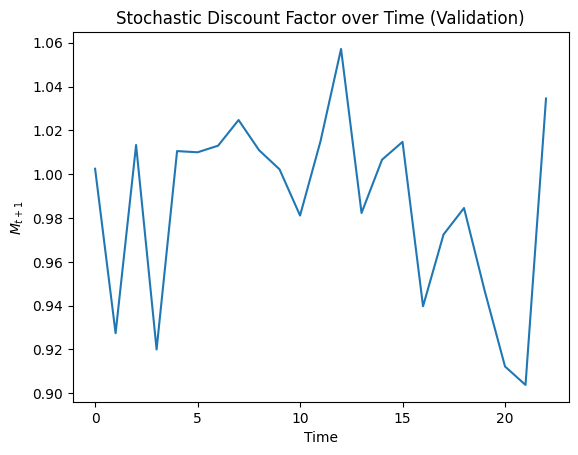

In [8]:
plt.plot(val_M_tp1_fit)
plt.title("Stochastic Discount Factor over Time (Validation)")
plt.ylabel("$M_{t+1}$")
plt.xlabel("Time")
plt.show()

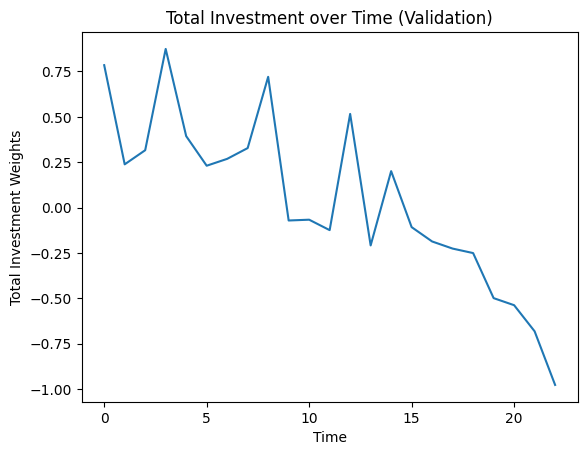

In [9]:
plt.plot(np.sum(val_omega_t_fit, axis=1))
plt.title("Total Investment over Time (Validation)")
plt.ylabel("Total Investment Weights")
plt.xlabel("Time")
plt.show()

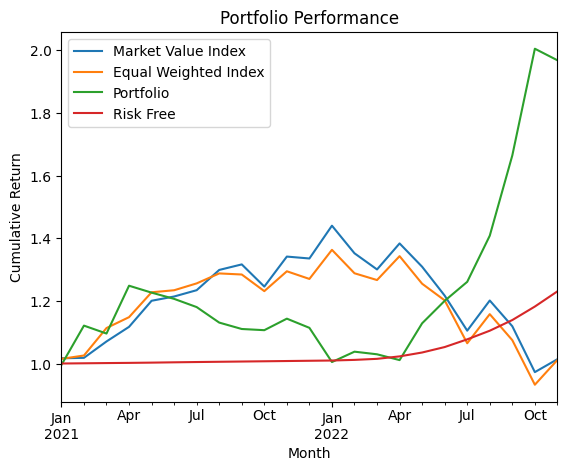

In [24]:
df = pd.read_excel("./index.xlsx").set_index("date").loc[val_d["FEDFUNDS"].columns].iloc[:-1]
df = df.rename({"index_excess_return": "Market Value Index", "equal_weighted_excess_return": "Equal Weighted Index"}, axis=1)
val_df = pd.read_excel("./validation_dataset.xlsx", sheet_name="FEDFUNDS", index_col="conm")
df["Portfolio"] = val_r + 1. + val_d["FEDFUNDS"].values[0, 1:]
df["Risk Free"] = val_d["FEDFUNDS"].values[0, 1:] + 1.
cdf = val_df
(df["Market Value Index"] + 1. + cdf.values[0, :-1]).cumprod().plot()
(df["Equal Weighted Index"] + 1. + cdf.values[0, :-1]).cumprod().plot()
df["Portfolio"].cumprod().plot()
df["Risk Free"].cumprod().plot()
plt.legend()
plt.ylabel("Cumulative Return")
plt.xlabel("Month")
plt.title("Portfolio Performance")
plt.show()

Sharpe Ratio: 0.3324963293326138


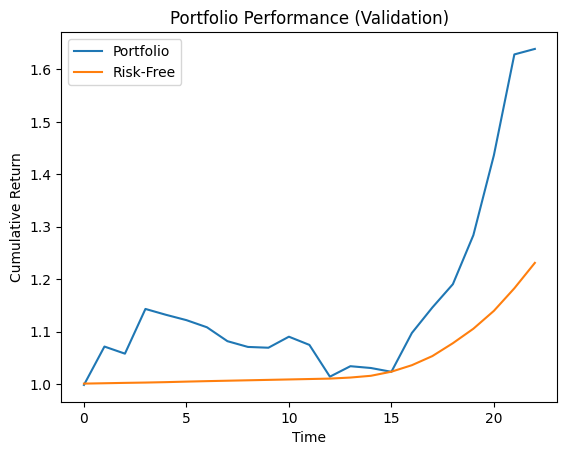

In [10]:
print("Sharpe Ratio:", np.mean(val_r)/np.std(val_r))
plt.plot(np.cumprod(val_r + 1. + val_d["FEDFUNDS"].values[0, 1:]))[-1].set_label("Portfolio")
plt.plot(np.cumprod(val_d["FEDFUNDS"].values[0, 1:] + 1.))[-1].set_label("Risk-Free")
plt.legend()
plt.title("Portfolio Performance (Validation)")
plt.xlabel("Time")
plt.ylabel("Cumulative Return")
plt.show()

Sharpe Ratio: 0.22106501922621855


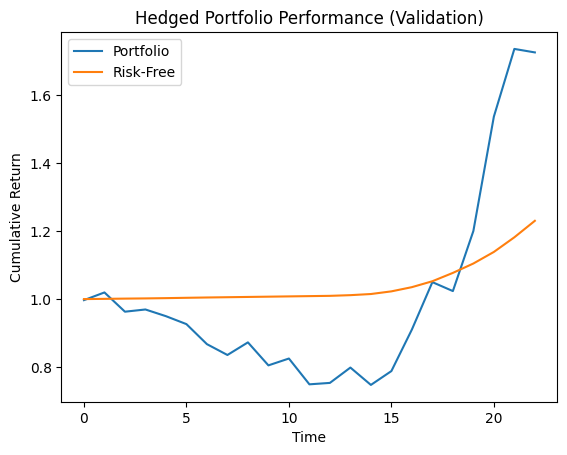

In [11]:
val_r_pair = val_r - index_re.loc[val_d["FEDFUNDS"].columns].values[1:]
print("Sharpe Ratio:", np.mean(val_r_pair)/np.std(val_r_pair))
plt.plot(np.cumprod(val_r_pair + 1. + val_d["FEDFUNDS"].values[0, 1:]))[-1].set_label("Portfolio")
plt.plot(np.cumprod(val_d["FEDFUNDS"].values[0, 1:] + 1.))[-1].set_label("Risk-Free")
plt.legend()
plt.title("Hedged Portfolio Performance (Validation)")
plt.xlabel("Time")
plt.ylabel("Cumulative Return")
plt.show()

In [12]:
def sharpe_by_lambda(l):
    b, _ = optimize(l, verbose=False)
    val_omega_t_fit = tf.einsum("ijk, k -> ij", val_X[:-1, :, :], b).numpy()
    r = np.sum(val_omega_t_fit * val_re_tp1, axis=1)
    return np.mean(r)/np.std(r)

sharpes = []
for i in tqdm(range(200)):
    sharpes.append(sharpe_by_lambda(i/10))

100%|██████████| 200/200 [58:44<00:00, 17.62s/it] 


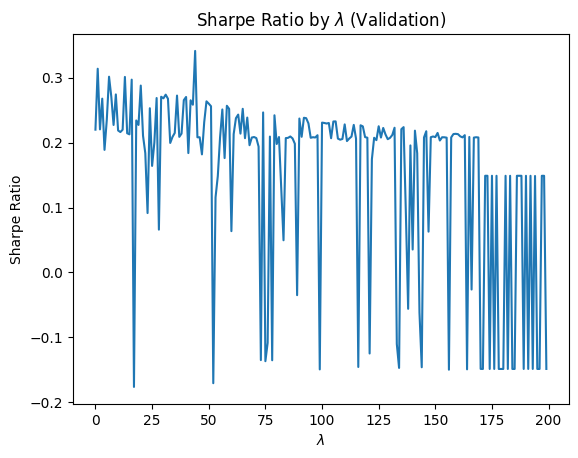

In [13]:
plt.plot(sharpes)
plt.title("Sharpe Ratio by $\lambda$ (Validation)")
plt.xlabel("$\lambda$")
plt.ylabel("Sharpe Ratio")
plt.show()

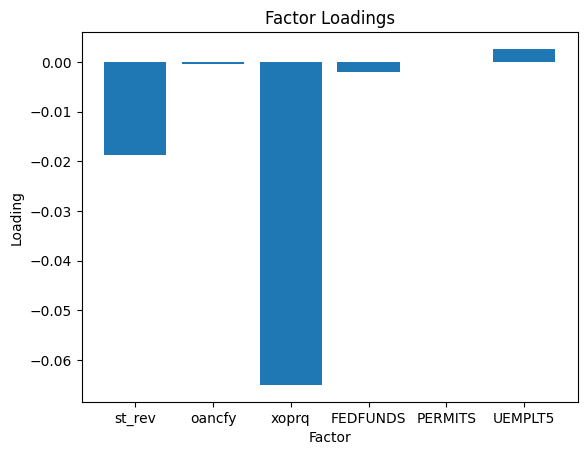

In [30]:
plt.bar(["st_rev", "oancfy", "xoprq", "FEDFUNDS", "PERMITS", "UEMPLT5"], [-1.87175423e-02, -3.20296791e-04, -6.50558701e-02, -2.04421294e-03,
  5.14936984e-05,  2.67174006e-03])
plt.title("Factor Loadings")
plt.xlabel("Factor")
plt.ylabel("Loading")
plt.show()

In [ ]:
print("field", "mean", "std", "min", "max", "median")
for s, v in zip(sheets, d.values()):
    print(s, v.values.mean(), v.values.std(), v.values.min(), v.values.max(), np.quantile(v.values, .5))

field mean std min max median
st_rev -0.005675085916615251 0.34960875595072866 -21.53176100628931 2.994069899425501 -0.0015214715948586501
oancfy 289.99743653846156 394.5329907007922 -164.0 3807.831 158.7755
xoprq 191.28378653846156 216.69729233382566 1.392 1391.0 120.4165
FEDFUNDS 0.009824999999999999 0.00824622388328945 0.0005 0.0242 0.00725
PERMITS 660.9166666666666 84.65842315511854 523 900 641.0
UEMPLT5 2500.9305555555557 1432.236637865453 1849 14263 2294.0
excess_return -0.007844067195559338 0.09404595138432267 -0.7247899118511264 2.972685082872928 -0.00955546354115085


In [40]:
print((df["Equal Weighted Index"].mean()/df["Equal Weighted Index"].std()))
print(df["Market Value Index"].mean()/df["Market Value Index"].std())

-0.07434301518626994
-0.07352726727249337
